In [1]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

In [2]:
X[:10]

array([[-0.201213  ,  0.28808287],
       [ 0.92670161, -0.17007869],
       [-0.54141113,  0.77194143],
       [-0.44251885, -0.83976482],
       [ 0.30471255, -0.9159678 ],
       [ 0.11895822, -0.26454139],
       [ 0.83515802, -0.50530766],
       [-0.84280451,  0.49533718],
       [-0.35271995,  0.26198348],
       [ 0.27862207, -0.04298763]])

In [3]:
y[:10]

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1], dtype=int64)

(-2.0, 2.0)

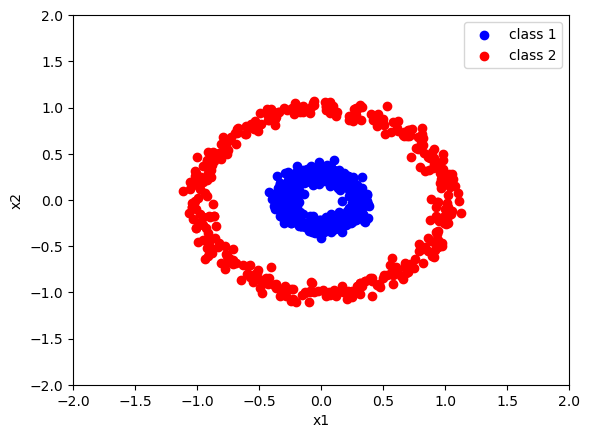

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
plt.legend(loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
import time
import torch
from torch import nn
from torch.nn import BCELoss

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = nn.Sequential(nn.Linear(2, 10),
                    nn.ReLU(),
                    nn.Linear(10, 10),
                    nn.ReLU(),
                    nn.Linear(10, 1), #binary has ony one output
                    nn.Sigmoid()).to(device)

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

batch_size = 4
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

In [9]:
loss = BCELoss(reduction='mean')
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [10]:
epochs = 100
train_losses = []
test_losses = []
for epoch in range(epochs):
    start = time.time()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device).view(-1, 1)
        output = net(data)
        L = loss(output, target)
        L.backward()
        optimizer.step()

    y_train_pred_proba = net(X_train)
    training_loss = loss(y_train_pred_proba, y_train.view(-1, 1)).item()    
    y_test_pred_proba = net(X_test)
    test_loss = loss(y_test_pred_proba, y_test.view(-1, 1)).item()
    train_losses.append(training_loss)
    test_losses.append(test_loss)
    
    end = time.time()
    print("Epoch {}: Train_loss {}, Validation_loss {}, Seconds {}".format(epoch, training_loss, test_loss, end-start))

Epoch 0: Train_loss 0.034932564944028854, Validation_loss 0.03705484792590141, Seconds 0.09456229209899902
Epoch 1: Train_loss 0.0038469727151095867, Validation_loss 0.004369623959064484, Seconds 0.08132457733154297
Epoch 2: Train_loss 0.0015069358050823212, Validation_loss 0.0017629223875701427, Seconds 0.0718691349029541
Epoch 3: Train_loss 0.0008134476374834776, Validation_loss 0.0009624415542930365, Seconds 0.07699918746948242
Epoch 4: Train_loss 0.0005091132479719818, Validation_loss 0.0006106896908022463, Seconds 0.07580184936523438
Epoch 5: Train_loss 0.000347408204106614, Validation_loss 0.00042293110163882375, Seconds 0.06729435920715332
Epoch 6: Train_loss 0.00025195840862579644, Validation_loss 0.00031196922645904124, Seconds 0.07456302642822266
Epoch 7: Train_loss 0.00019060919294133782, Validation_loss 0.0002398376673227176, Seconds 0.07981514930725098
Epoch 8: Train_loss 0.0001487235422246158, Validation_loss 0.0001898606278700754, Seconds 0.07259345054626465
Epoch 9: Tra

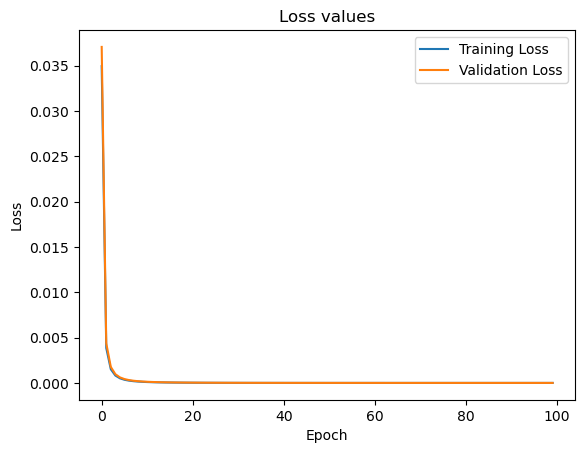

In [11]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [12]:
y_test_pred_proba = net(X_test)
y_test_pred = (y_test_pred_proba.detach().numpy() >= 0.5).astype(int)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        81
         1.0       1.00      1.00      1.00        69

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [14]:
confusion_matrix(y_test,y_test_pred)

array([[81,  0],
       [ 0, 69]], dtype=int64)

Text(0.5, 1.0, 'Receiver Operating Characteristic - PyTorch')

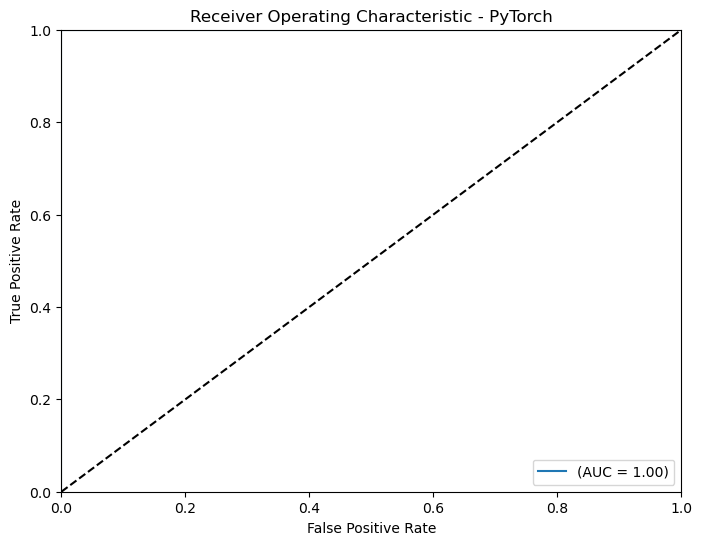

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - PyTorch')